In [1]:
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.ecm.advancedSOH import ECMASOH
from moirae.models.ecm.ins_outs import ECMInput
from moirae.models.ecm.transient import ECMTransientVector
from moirae.simulator import Simulator
from moirae.estimators.online.dual import DualEstimator
from moirae.estimators.online.utils.model import CellModelWrapper, DegradationModelWrapper
from moirae.estimators.online.filters.conversions import LinearConversionOperator, AbsoluteValueConversionOperator
from moirae.estimators.online.filters.distributions import MultivariateGaussian, DeltaDistribution
from moirae.estimators.online.filters.kalman.unscented import UnscentedKalmanFilter as UKF

In [2]:
def cycle(start_time=0) -> Tuple[float, List[ECMInput]]:
    # Charge for 3 hours at a current of 3 A
    chg_time = 3 * 3600
    final_time = start_time + chg_time
    inputs = [ECMInput(time=time, current=3) for time in np.arange(start_time, final_time)]
    # Now, discharge for 4 hours at a current of 2.25 A
    dischg_time = 4 * 3600
    final_time += dischg_time
    inputs += [ECMInput(time=time, current=-2.25) for time in np.arange(start_time + chg_time, final_time)]
    return final_time, inputs


def get_protocol(num_cycles: int) -> List[ECMInput]:
    """
    Defines cycling protocol for tests
    """
    # Create inputs for the cell
    protocol = []

    start_time = 1
    for _ in range(num_cycles):
        end_time, new_inputs = cycle(start_time=start_time)
        protocol += new_inputs
        start_time = end_time + 1

    return protocol

In [3]:
def real_initialization() -> Tuple[ECMTransientVector, ECMASOH, Simulator]:
    """
    Provides real objects for simulation
    """
    # Create simplest possible Rint model, with no hysteresis, and only R0
    real_transients = ECMTransientVector.provide_template(has_C0=False, num_RC=0, soc=0.1)
    real_asoh = ECMASOH.provide_template(has_C0=False, num_RC=0,
                                         R0=1., # np.array([[0.5, 1.5]]), #
                                         H0=0.05)
    # real_asoh.h0.gamma = 10.
    # Prepare simulator
    simulator = Simulator(model=ECM(),
                          asoh=real_asoh,
                          transient_state=real_transients,
                          initial_input=ECMInput(),
                          keep_history=True)

    return real_transients, real_asoh, simulator

In [4]:
def initial_guesses() -> Tuple[ECMTransientVector, ECMASOH]:
    """
    Provides initial guesses for dual estimation
    """
    # Create initial guesses
    guess_transients = ECMTransientVector.provide_template(has_C0=False, num_RC=0)
    guess_asoh = ECMASOH.provide_template(has_C0=False, num_RC=0,
                                          qt=11., 
                                          R0=2., # np.array([[1.5, 2.5]]), #
                                          H0=0.05)
    # guess_asoh.h0.gamma = 10.
    guess_asoh.mark_updatable(name='q_t.base_values')
    guess_asoh.mark_updatable(name='r0.base_values')
    # guess_asoh.mark_updatable(name='h0.base_values')
    return guess_transients, guess_asoh

In [5]:
def initial_uncertainties() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Provides covariance matrices for initial transient guess, initial A-SOH guess, and transient covariance process
    noise
    """
    cov_transient = np.diag([1/12, 1.0e-06])  # 4 * (guess_asoh.h0.base_values.item() ** 2) / 12])
    cov_asoh = 0.1 * np.eye(2) # np.atleast_2d(0.1) # 
    cov_trans_process = np.diag([1.0e-08, 1.0e-16])
    return cov_transient, cov_asoh, cov_trans_process

In [6]:
# Get protocol
protocol = get_protocol(num_cycles=20)

# Collect real values
real_transients, real_asoh, simulator = real_initialization()

# Get initial guesses
guess_transients, guess_asoh = initial_guesses()

# Prepare the dual estimation
cov_transient, cov_asoh, cov_trans_process = initial_uncertainties()

# Start with the transient states, which are easier
trans_wrap = CellModelWrapper(cell_model=ECM(),
                              asoh=guess_asoh,
                              transients=guess_transients,
                              inputs=simulator.previous_input.model_copy(deep=True))
# Now, create the wrapper for the A-SOH filter
asoh_wrap = DegradationModelWrapper(cell_model=ECM(),
                                    asoh=guess_asoh,
                                    transients=guess_transients,
                                    inputs=simulator.previous_input.model_copy(deep=True),
                                    converters={'hidden_conversion_operator': AbsoluteValueConversionOperator()})

dual_ukf = DualEstimator.initialize_ukf_from_wrappers(
    transient_wrapper=trans_wrap,
    asoh_wrapper=asoh_wrap,
    covariance_transient=cov_transient,
    covariance_asoh=cov_asoh,
    transient_covariance_process_noise=cov_trans_process,
    covariance_sensor_noise=np.atleast_2d(1.0e-06)
)

# dual_ukf = DualEstimator.initialize_unscented_kalman_filter(
#     cell_model=ECM(),
#     initial_asoh=guess_asoh,
#     initial_transients=guess_transients,
#     initial_inputs=simulator.previous_input,
#     covariance_asoh=cov_asoh,
#     covariance_transient=cov_transient,
#     covariance_sensor_noise=np.atleast_2d(1.0e-06),
#     transient_covariance_process_noise=cov_trans_process)

# Prepare dictionary to store results
dual_results = {'estimates': [], 'predictions': []}
# Co-simulate
for new_input in tqdm(protocol):
    _, cell_response = simulator.step(new_inputs=new_input)
    est_hid, pred_out = dual_ukf.step(inputs=new_input, measurements=cell_response)
    dual_results['estimates'] += [est_hid]
    dual_results['predictions'] += [pred_out]


100%|██████████| 504000/504000 [09:44<00:00, 862.97it/s]


In [7]:
# Prepare variables for plotting
timestamps = np.array([inputs.time.item() for inputs in protocol]) / 3600.
real_soc = np.array([transient.soc.item() for transient in simulator.transient_history[1:]])
real_hyst = np.array([transient.hyst.item() for transient in simulator.transient_history[1:]])
real_volts = np.array([measurement.terminal_voltage.item()
                        for measurement in simulator.measurement_history[1:]])
real_r0 = np.repeat(real_asoh.r0.base_values.T, len(timestamps), axis=1).T
# print(real_r0.shape)
real_qt = real_asoh.q_t.base_values.item() * np.ones(len(timestamps))
real_h0 = real_asoh.h0.base_values.item() * np.ones(len(timestamps))

est_soc = np.array([est.get_mean()[0] for est in dual_results['estimates']])
est_hyst = np.array([est.get_mean()[1] for est in dual_results['estimates']])
est_qt = np.array([est.get_mean()[2] for est in dual_results['estimates']])
est_r0 = np.array([est.get_mean()[3] for est in dual_results['estimates']])
est_h0 = np.array([est.get_mean()[-1] for est in dual_results['estimates']])
est_soc_err = np.array([2 * np.sqrt(est.get_covariance()[0, 0]) for est in dual_results['estimates']])
est_hyst_err = np.array([2 * np.sqrt(est.get_covariance()[1, 1]) for est in dual_results['estimates']])
est_qt_err = np.array([2 * np.sqrt(est.get_covariance()[2, 2]) for est in dual_results['estimates']])
est_r0_err = np.array([2 * np.sqrt(est.get_covariance()[3, 3]) for est in dual_results['estimates']])
est_h0_err = np.array([2 * np.sqrt(est.get_covariance()[-1, -1]) for est in dual_results['estimates']])
pred_volts = np.array([prediction.get_mean()[0] for prediction in dual_results['predictions']])
pred_volts_err = np.array([2 * np.sqrt(prediction.get_covariance()[0, 0])
                            for prediction in dual_results['predictions']])

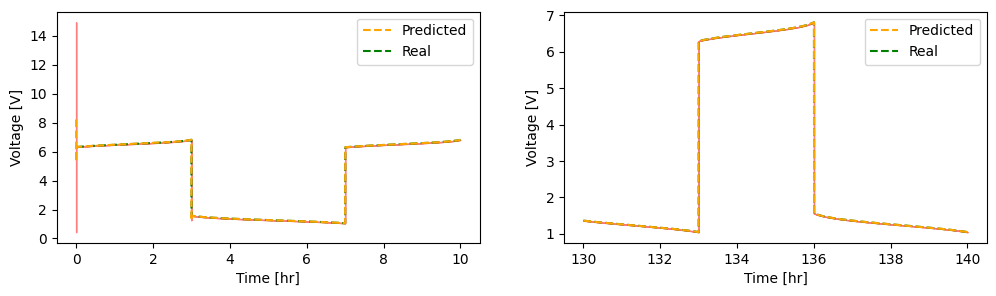

In [8]:
# Plot Vt

# Choose the first and last entries to plot for clarity
first_entries = 36000
last_entries = 36000

fig, axes = plt.subplots(1,2,figsize=(12,3))
axes[0].plot(timestamps[:first_entries], pred_volts[:first_entries],
          linestyle = '--', 
          color='orange',
          label='Predicted',
          zorder=2)
axes[0].plot(timestamps[:first_entries], real_volts[:first_entries],
          linestyle = '--', 
          color='green',
          label='Real',
          zorder=1)
axes[0].fill_between(timestamps[:first_entries],
                     (pred_volts + pred_volts_err)[:first_entries],
                     (pred_volts - pred_volts_err)[:first_entries],
                  color='red',
                  alpha=0.5,
                  zorder=0)
axes[1].plot(timestamps[-last_entries:], pred_volts[-last_entries:],
          linestyle = '--', 
          color='orange',
          label='Predicted',
          zorder=2)
axes[1].plot(timestamps[-last_entries:], real_volts[-last_entries:],
          linestyle = '--', 
          color='green',
          label='Real',
          zorder=1)
axes[1].fill_between(timestamps[-last_entries:],
                     (pred_volts + pred_volts_err)[-last_entries:],
                     (pred_volts - pred_volts_err)[-last_entries:],
                  color='red',
                  alpha=0.5,
                  zorder=0)

for ax in axes:
    ax.legend()
    ax.set_xlabel('Time [hr]')
    ax.set_ylabel('Voltage [V]')


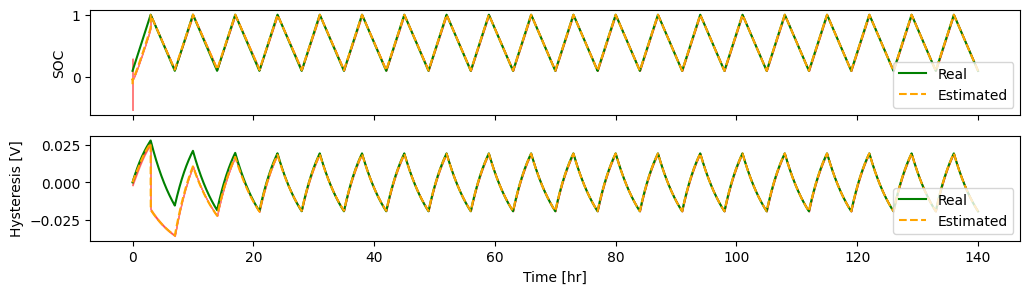

In [9]:
# Transients
fig, axes = plt.subplots(2, 1, sharex='col', figsize=(12,3))

axes[0].plot(timestamps, real_soc,
             color='green',
             label='Real',
             zorder=1)
axes[0].plot(timestamps, est_soc,
             linestyle='--',
             color='orange',
             label='Estimated',
             zorder=2)
axes[0].fill_between(timestamps, est_soc + est_soc_err, est_soc - est_soc_err,
                     color='red',
                     alpha=0.5,
                     zorder=0)

axes[1].plot(timestamps, real_hyst,
             color='green',
             label='Real',
             zorder=1)
axes[1].plot(timestamps, est_hyst,
             linestyle='--',
             color='orange',
             label='Estimated',
             zorder=2)
axes[1].fill_between(timestamps, est_hyst + est_hyst_err, est_hyst - est_hyst_err,
                     color='red',
                     alpha=0.5,
                     zorder=0)

axes[0].set_ylabel('SOC')
axes[1].set_ylabel('Hysteresis [V]')
# axes[2].set_ylabel(r'$I_{RC}$ [V]')
axes[-1].set_xlabel('Time [hr]')
for ax in axes:
    ax.legend()

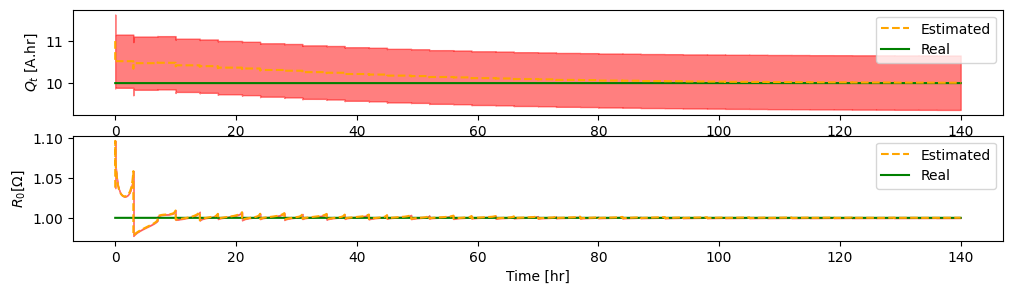

In [11]:
# A-SOH
fig, axes = plt.subplots(2,1,figsize=(12,3))

axes[0].plot(timestamps[:], est_qt[:],
             linestyle='--',
             color='orange',
             label='Estimated',
             zorder=2)
axes[0].fill_between(timestamps[:],
                     (est_qt + est_qt_err)[:],
                     (est_qt - est_qt_err)[:],
                     color='red',
                     alpha=0.5,
                     zorder=0)
axes[0].plot(timestamps[:], real_qt[:],
             color='green',
             label='Real',
             zorder=1)
# axes[0].plot(timestamps[:], real_r0[:, 0],
#              color='green',
#              label='Real',
#              zorder=1)

axes[1].plot(timestamps[:], est_r0[:],
             linestyle='--',
             color='orange',
             label='Estimated',
             zorder=2)
axes[1].fill_between(timestamps[:],
                     (est_r0 + est_r0_err)[:],
                     (est_r0 - est_r0_err)[:],
                     color='red',
                     alpha=0.5,
                     zorder=0)
axes[1].plot(timestamps[:], real_r0[:],
             color='green',
             label='Real',
             zorder=1)

# axes[2].plot(timestamps[:], est_h0[:],
#              linestyle='--',
#              color='orange',
#              label='Estimated',
#              zorder=2)
# axes[2].fill_between(timestamps[:],
#                      (est_h0 + est_h0_err)[:],
#                      (est_h0 - est_h0_err)[:],
#                      color='red',
#                      alpha=0.5,
#                      zorder=0)


axes[0].set_ylabel(r'$Q_t$ [A.hr]')
# axes[0].set_ylabel(r'$R_0$ at 0% $[\Omega]$')
axes[1].set_ylabel(r'$R_0 [\Omega]$')
# axes[1].set_ylabel(r'$R_0$ at 100% $[\Omega]$')
# axes[2].set_ylabel(r'$H_0$ [V]')
axes[-1].set_xlabel('Time [hr]')
for ax in axes:
    ax.legend()

In [11]:
# Check stats
# consider the last 3 hours of simulation
last_pts = 2 * 3600
volt_capt = np.isclose(real_volts[-last_pts:],
                        pred_volts[-last_pts:],
                        atol=pred_volts_err[-last_pts:]).sum()/last_pts
soc_capt = np.isclose(real_soc[-last_pts:],
                        est_soc[-last_pts:],
                        atol=est_soc_err[-last_pts:]).sum()/last_pts
hyst_capt = np.isclose(real_hyst[-last_pts:],
                        est_hyst[-last_pts:],
                        atol=est_hyst_err[-last_pts:]).sum()/last_pts
r0_capt = np.isclose(real_r0[-last_pts:],
                        est_r0[-last_pts:],
                        atol=est_r0_err[-last_pts:]).sum()/last_pts

assert volt_capt >= 0.95, f'Percentage of voltage within error: {volt_capt}'
assert soc_capt >= 0.95, f'Percentage of SOC within error: {soc_capt}'
# Hysteresis only converges fully closer to 10 cycles... :(
assert hyst_capt >= 0.0, 'Now that makes no sense!'
# assert hyst_capt >= 0.95, f'Percentage of hysteresis within error: {hyst_capt}'
assert r0_capt >= 0.95, f'Percentage of R0 within error: {r0_capt}'

AssertionError: Percentage of SOC within error: 0.0

In [12]:
dual_results['estimates'][-1]

MultivariateGaussian(mean=array([1.29615723e+00, 2.61302406e-05, 2.22097955e+01]), covariance=array([[ 4.67037144e-09, -1.47608491e-13,  0.00000000e+00],
       [-1.47608491e-13,  1.78330154e-12,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  7.18026266e-03]]), num_dimensions=3)

In [12]:
real_r0[-1,:]

array([0.5, 1.5])